## Malaria Detection Using Transfer Learning: VGG19 

Team: Malar-ai.netlify.app

Biomedical Engineering
Addis Ababa Institute of Technology
Addis Ababa University

In [1]:
#importing useful libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import imageio
from datetime import datetime as dt
from PIL import Image
from tqdm import tqdm
#Importing the deep learning libraries
#from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array,array_to_img
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K
from keras.optimizers import RMSprop
from keras import regularizers as reg
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
from keras import optimizers
from keras.callbacks import History

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abrahamgenetutaye","key":"2f59722e846de26a34992f95947cbd04"}'}

In [3]:
!ls -lha kaggle.json

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 73 Jun 24 11:47 kaggle.json


In [4]:
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list -s malaria


ref                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
imdevskp/malaria-dataset                            Malaria Dataset                                      52KB  2020-07-01 17:28:22           5731         88  1.0              
iarunava/cell-images-for-detecting-malaria          Malaria Cell Images Dataset                         675MB  2018-12-05 05:40:21          44358       1189  0.625            
kmader/malaria-bounding-boxes                       Malaria Bounding Boxes                                4GB  2019-05-09 13:37:54           3520        118  0.75             
miracle9to9/files1                                  Malaria Dataset                                     525MB  2020-01-0

In [5]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 675M/675M [00:05<00:00, 143MB/s]
100% 675M/675M [00:05<00:00, 132MB/s]


In [7]:
!unzip /content/cell-images-for-detecting-malaria.zip -d malaria-detection-dataset

Streaming output truncated to the last 5000 lines.
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: malaria-detection-dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png

In [8]:
import os

# Define the paths to the folders containing the uninfected and parasitized images
path_uninfected = 'malaria-detection-dataset/cell_images/Uninfected/'
path_parasitized = 'malaria-detection-dataset/cell_images/Parasitized/'

# Get all the filenames from the original "cell_images" data folder
parasitized_filenames = os.listdir(path_parasitized)
uninfected_filenames = os.listdir(path_uninfected)

# Get details about the number of images present
print("Number of images of type 'Parasitized':", len(parasitized_filenames))
print("Number of images of type 'Uninfected':", len(uninfected_filenames))

Number of images of type 'Parasitized': 13780
Number of images of type 'Uninfected': 13780


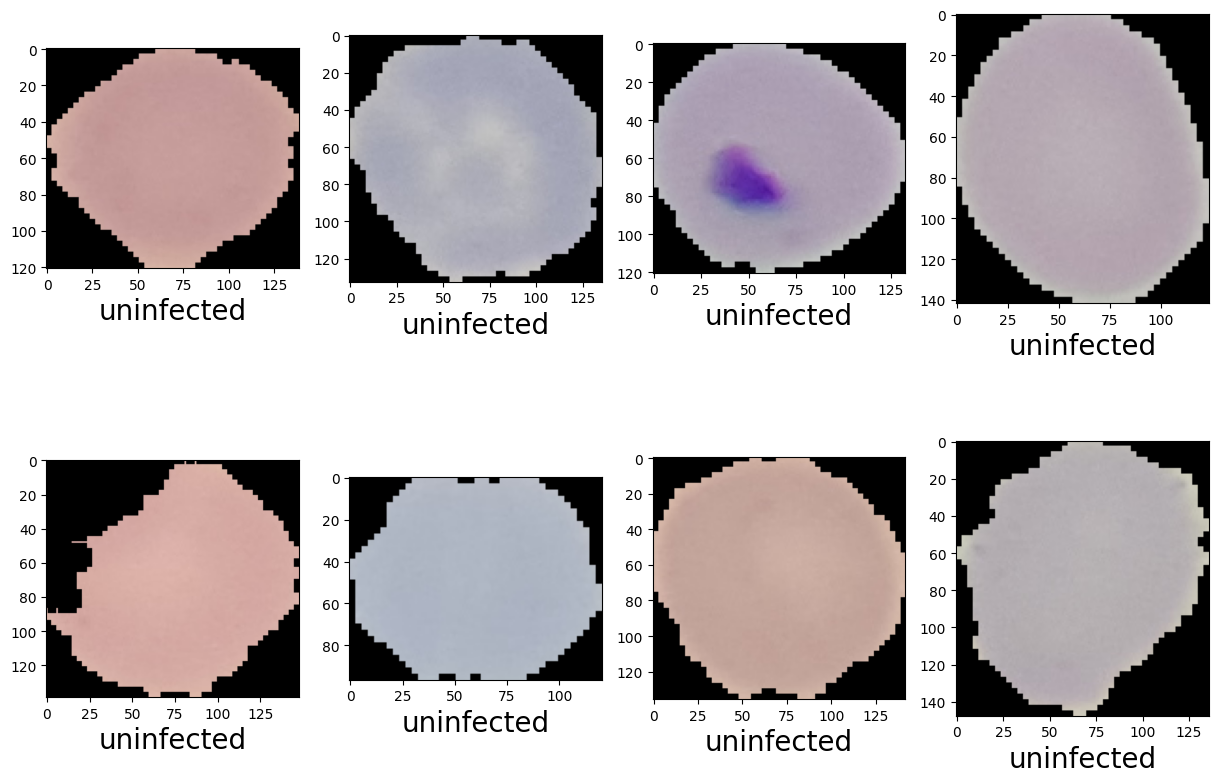

In [9]:
# Set up the canvas for the subplots with a size of 20x10 inches
plt.figure(figsize=(15,10))

# Create a subplot grid with 2 rows and 4 columns
# The first subplot will be located at position 1
plt.subplot(2,4,1)

# Loop over 8 subplots, starting from position 1
for i in range(1,9):

    # Select the next subplot in the grid
    plt.subplot(2,4,i)

    # Get a random image from the uninfected list
    image = uninfected_filenames[i]

    # Read the image file from the uninfected folder and convert it to an array
    img_array = plt.imread(path_uninfected + image)

    # Display the image in the current subplot
    plt.imshow(img_array)

    # Set the xlabel of the current subplot to 'uninfected' with a font size of 20
    plt.xlabel('uninfected', fontsize=20)

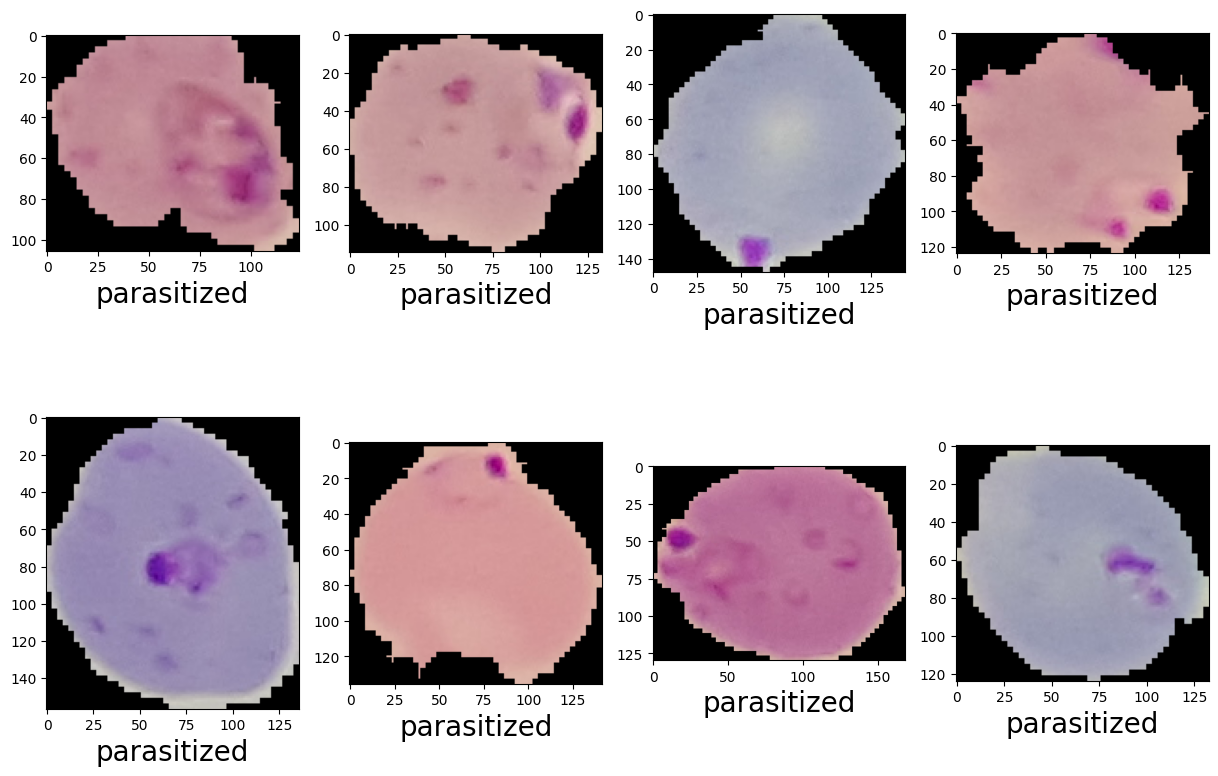

In [10]:
# Set up the canvas for the subplots with a size of 20x10 inches
plt.figure(figsize=(15,10))

# Create a subplot grid with 2 rows and 4 columns
# The first subplot will be located at position 1
plt.subplot(2,4,1)

# Loop over 8 subplots, starting from position 1
for i in range(1,9):

    # Select the next subplot in the grid
    plt.subplot(2,4,i)

    # Get a random image from the parasitized list
    image = parasitized_filenames[i]

    # Read the image file from the parasitized folder and convert it to an array
    img_array = plt.imread(path_parasitized + image)

    # Display the image in the current subplot
    plt.imshow(img_array)

    # Set the xlabel of the current subplot to 'parasitized' with a font size of 20
    plt.xlabel('parasitized', fontsize=20)

In [11]:
# Create necessary folders if they don't exist
!mkdir -p train/Parasitized
!mkdir -p train/Uninfected
!mkdir -p validation/Parasitized
!mkdir -p validation/Uninfected
!mkdir -p test/Parasitized
!mkdir -p test/Uninfected

**Preprocessing of the datasets**

In [12]:
def resize_image(image_path):
  '''
  Function to resize an image into 128 *128
  '''
  resized_image = cv2.resize(image_path, (128,128), interpolation = cv2.INTER_AREA) # cv2.INTER_AREA: This is used when we need to shrink an image.

  return resized_image


**Train-Test Split**

In [13]:
# Image Data Preprocessing and splitting the images into train, validation and test for parasitized image
# Specify the location of the Parasitized folder
par_folder_path = "/content/malaria-detection-dataset/cell_images/Parasitized"

# Randomly sample Parasitized images for train, test, and validation split
par_train_images = random.sample(parasitized_filenames, 8000)
par_val_images = random.sample(list(set(parasitized_filenames) - set(par_train_images)), 3000) #excluding file names which are present in train
par_test_images = list(set(parasitized_filenames) - set(par_train_images) - set(par_val_images)) # excluding file name which are already in train and validation



In [14]:

# Create train folder and save resized images
for file in tqdm(par_train_images):
    if file.endswith("png"):
        image = imageio.imread(os.path.join(par_folder_path, file)) # reading and image --> returns a numpy array, which comes with a dict of meta data at its ‘meta’ attribute.
        resized_image = resize_image(image) # resizing the image into 128 *128
        imageio.imsave(os.path.join("train/Parasitized", file), resized_image) # saving all the resized images in the train's parastized folder
print("Train folder created for Parasitized images...")

# Create validation folder and save resized images
for file in tqdm(par_val_images):
    if file.endswith("png"):
        image = imageio.imread(os.path.join(par_folder_path, file))
        resized_image = resize_image(image)
        imageio.imsave(os.path.join("validation/Parasitized", file), resized_image)
print("Validation folder created for Parasitized images...")

# Create test folder and save resized images
for file in tqdm(par_test_images):
    if file.endswith("png"):
        image = imageio.imread(os.path.join(par_folder_path, file))
        resized_image = resize_image(image)
        imageio.imsave(os.path.join("test/Parasitized", file), resized_image)
print("Test folder created for Parasitized images...")

100%|██████████| 8000/8000 [03:40<00:00, 36.20it/s]


Train folder created for Parasitized images...


100%|██████████| 3000/3000 [01:22<00:00, 36.43it/s]


Validation folder created for Parasitized images...


100%|██████████| 2780/2780 [01:17<00:00, 35.89it/s]

Test folder created for Parasitized images...


In [15]:
# Specify the location of the Uninfected folder
# Image Data Preprocessing and splitting the images into train, validation and test for Uninfected  images
unin_folder_path = "/content/malaria-detection-dataset/cell_images/Uninfected"

# Randomly sample Uninfected images for train, test, and validation split
unin_train_images = random.sample(uninfected_filenames, 8000)
unin_val_images = random.sample(list(set(uninfected_filenames) - set(unin_train_images)), 3000)
unin_test_images = list(set(uninfected_filenames) - set(unin_train_images) - set(unin_val_images))

In [16]:

# Create train folder and save resized images
for file in tqdm(unin_train_images):
    if file.endswith("png"):
        image = imageio.imread(os.path.join(unin_folder_path, file))
        resized_image = resize_image(image)
        imageio.imsave(os.path.join("train/Uninfected", file), resized_image)
print("Train folder created for Uninfected images...")

# Create validation folder and save resized images
for file in tqdm(unin_val_images):
    if file.endswith("png"):
        image = imageio.imread(os.path.join(unin_folder_path, file))
        resized_image = resize_image(image)
        imageio.imsave(os.path.join("validation/Uninfected", file), resized_image)
print("Validation folder created for Uninfected images...")

# Create test folder and save resized images
for file in tqdm(unin_test_images):
    if file.endswith("png"):
        image = imageio.imread(os.path.join(unin_folder_path, file))
        resized_image = resize_image(image)
        imageio.imsave(os.path.join("test/Uninfected", file), resized_image)
print("Test folder created for Uninfected images...")


100%|██████████| 8000/8000 [04:12<00:00, 31.73it/s]


Train folder created for Uninfected images...


100%|██████████| 3000/3000 [01:34<00:00, 31.76it/s]


Validation folder created for Uninfected images...


100%|██████████| 2780/2780 [01:26<00:00, 32.22it/s]

Test folder created for Uninfected images...


**Preprocessing of Training Datasets**

In [18]:
# Train Data Preparation
train_file_names = [] # list to store the image files name of train data for both parasitized and uninfected

train_file_parasitized = []
for file_name in os.listdir("train/Parasitized"):
    train_file_parasitized.append("train/Parasitized/"+file_name)

print(train_file_parasitized)
train_file_uninfected = []
for file_name in os.listdir("train/Uninfected"):
    train_file_uninfected.append("train/Uninfected/"+file_name)
print(train_file_uninfected)
train_file_names = train_file_parasitized + train_file_uninfected


['train/Parasitized/C140P101ThinF_IMG_20151005_205406_cell_161.png', 'train/Parasitized/C84P45ThinF_IMG_20150818_102800_cell_8.png', 'train/Parasitized/C37BP2_thinF_IMG_20150620_133205a_cell_88.png', 'train/Parasitized/C46P7ThinF_IMG_20151130_210843_cell_136.png', 'train/Parasitized/C68P29N_ThinF_IMG_20150819_134326_cell_149.png', 'train/Parasitized/C76P37ThinF_IMG_20150815_172808_cell_220.png', 'train/Parasitized/C39P4thinF_original_IMG_20150622_111206_cell_102.png', 'train/Parasitized/C91P52ThinF_IMG_20150821_124311_cell_39.png', 'train/Parasitized/C115P76ThinF_IMG_20150930_162315_cell_256.png', 'train/Parasitized/C70P31_ThinF_IMG_20150813_131708_cell_3.png', 'train/Parasitized/C99P60ThinF_IMG_20150918_142128_cell_92.png', 'train/Parasitized/C187P148NThinF_IMG_20151203_153036_cell_126.png', 'train/Parasitized/C184P145ThinF_IMG_20151203_104153_cell_137.png', 'train/Parasitized/C123P84ThinF_IMG_20151002_152330_cell_202.png', 'train/Parasitized/C172P133ThinF_IMG_20151119_155019_cell_239

In [25]:

X_train = [imageio.imread(image) for image in train_file_names] # Read each image file from the train data
X_train = np.array(X_train) # Converting into numpy array

# Generating Class label for train data
#y_train = ["Parasitized"]*8000 + ["Uninfected"]*8000
y_train =  ["Parasitized"]*len(train_file_parasitized) + ["Uninfected"]*len(train_file_uninfected)

In [19]:
print("train_file_parasitized :",len(train_file_parasitized))
print("train_file_parasitized :",len(train_file_uninfected))

train_file_parasitized : 8000
train_file_parasitized : 8000


**Preprocessing of Validation Datasets**

In [20]:
# Validation Data
val_file_names = []  # List to store the image file names of validation data for both parasitized and uninfected

val_file_parasitized = []
for file_name in os.listdir("validation/Parasitized"):
    val_file_parasitized.append("validation/Parasitized/" + file_name)

print(val_file_parasitized)

val_file_uninfected = []
for file_name in os.listdir("validation/Uninfected"):
    val_file_uninfected.append("validation/Uninfected/" + file_name)

print(val_file_uninfected)

val_file_names = val_file_parasitized + val_file_uninfected

X_val = [imageio.imread(image) for image in val_file_names]  # Read each image file from the validation data
X_val = np.array(X_val)  # Converting into numpy array

# Generating Class label for validation data
y_val = ["Parasitized"] * len(val_file_parasitized) + ["Uninfected"] * len(val_file_uninfected)


['validation/Parasitized/C84P45ThinF_IMG_20150818_101412_cell_103.png', 'validation/Parasitized/C183P144NThinF_IMG_20151201_223758_cell_145.png', 'validation/Parasitized/C182P143NThinF_IMG_20151201_172759_cell_28.png', 'validation/Parasitized/C80P41ThinF_IMG_20150817_112557_cell_19.png', 'validation/Parasitized/C39P4thinF_original_IMG_20150622_111206_cell_98.png', 'validation/Parasitized/C97P58ThinF_IMG_20150917_151512_cell_172.png', 'validation/Parasitized/C85P46ThinF_IMG_20150820_110143_cell_239.png', 'validation/Parasitized/C184P145ThinF_IMG_20151203_102721_cell_33.png', 'validation/Parasitized/C39P4thinF_original_IMG_20150622_114609_cell_13.png', 'validation/Parasitized/C39P4thinF_original_IMG_20150622_111942_cell_5.png', 'validation/Parasitized/C91P52ThinF_IMG_20150821_124739_cell_191.png', 'validation/Parasitized/C136P97ThinF_IMG_20151005_141803_cell_130.png', 'validation/Parasitized/C157P118ThinF_IMG_20151115_164141_cell_205.png', 'validation/Parasitized/C176P137NThinF_IMG_20151

In [21]:
print("val_file_parasitized :",len(val_file_parasitized))
print("val_file_parasitized :",len(val_file_uninfected))

val_file_parasitized : 2999
val_file_parasitized : 2999


**Preprocessing of Test Datasets**

In [22]:

# Test Data
test_file_names = []  # List to store the image file names of test data for both parasitized and uninfected

test_file_parasitized = []
for file_name in os.listdir("test/Parasitized"):
    test_file_parasitized.append("test/Parasitized/" + file_name)

print(test_file_parasitized)

test_file_uninfected = []
for file_name in os.listdir("test/Uninfected"):
    test_file_uninfected.append("test/Uninfected/" + file_name)

print(test_file_uninfected)

test_file_names = test_file_parasitized + test_file_uninfected

X_test = [imageio.imread(image) for image in test_file_names]  # Read each image file from the test data
X_test = np.array(X_test)  # Converting into numpy array

# Generating Class label for test data
y_test = ["Parasitized"] * len(test_file_parasitized) + ["Uninfected"] * len(test_file_uninfected)


['test/Parasitized/C82P43ThinF_IMG_20150817_124010_cell_186.png', 'test/Parasitized/C82P43ThinF_IMG_20150817_123500_cell_246.png', 'test/Parasitized/C60P21thinF_IMG_20150804_104919_cell_139.png', 'test/Parasitized/C184P145ThinF_IMG_20151203_102543_cell_173.png', 'test/Parasitized/C59P20thinF_IMG_20150803_113809_cell_14.png', 'test/Parasitized/C174P135NThinF_IMG_20151127_135554_cell_196.png', 'test/Parasitized/C189P150ThinF_IMG_20151203_140902_cell_114.png', 'test/Parasitized/C99P60ThinF_IMG_20150918_141129_cell_127.png', 'test/Parasitized/C187P148NThinF_IMG_20151203_153036_cell_129.png', 'test/Parasitized/C176P137NThinF_IMG_20151201_122444_cell_133.png', 'test/Parasitized/C163P124ThinF_IMG_20151116_110921_cell_242.png', 'test/Parasitized/C82P43ThinF_IMG_20150817_123652_cell_207.png', 'test/Parasitized/C87P48ThinF_IMG_20150820_132514_cell_200.png', 'test/Parasitized/C91P52ThinF_IMG_20150821_124504_cell_211.png', 'test/Parasitized/C180P141NThinF_IMG_20151201_165453_cell_12.png', 'test/Pa

In [23]:
print("test_file_parasitized :",len(test_file_parasitized))
print("test_file_parasitized :",len(test_file_uninfected))

test_file_parasitized : 2780
test_file_parasitized : 2780


In [26]:
print("Shape of Train Set : ",X_train.shape)
print("Shape of Validation Set : ",X_val.shape)
print("Shape of Test Set : ",X_test.shape)

Shape of Train Set :  (16000, 128, 128, 3)
Shape of Validation Set :  (5998, 128, 128, 3)
Shape of Test Set :  (5560, 128, 128, 3)


In [34]:
train_dir = os.path.join('train')
test_dir = os.path.join('test')
valid_dir = os.path.join('validation')
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Flatten, Dense, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import legacy, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.imagenet_utils import decode_predictions

In [32]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=0.4,
                                   vertical_flip=0.4,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=(128,128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    batch_size=32,
                                                    target_size=(128, 128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

class_labels = train_generator.class_indices
class_names = {value:key for (key, value) in class_labels.items()}

Found 16000 images belonging to 2 classes.
Found 5998 images belonging to 2 classes.


In [33]:
class_labels, class_names

({'Parasitized': 0, 'Uninfected': 1}, {0: 'Parasitized', 1: 'Uninfected'})

In [35]:
# Instantiate VGG19 model with weights from Imagenet without the calssifier at the top
base_model = VGG19(input_shape = (128,128,3),
                   include_top = False,
                   weights = 'imagenet')
# Freeze the ConvNet to avoid weight updates
for layer in base_model.layers:
    layer.trainable=False

x = base_model.output
flat=Flatten()(x)

# Add a classifier -  a fully connected dense layers
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

# Bake a model
model_01 = Model(base_model.inputs, output)
model_01.summary()

# Call backs
filepath = 'best_model.h5'
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.0001)

# Define an optimizer
sgd = legacy.SGD(lr=.0001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [36]:
# Fit the model on the training set and train for 10 epochs
history_01 = model_01.fit_generator(train_generator,
                                 steps_per_epoch=50,
                                 epochs=10,
                                 callbacks = [es, cp, lrr],
                                 validation_data = valid_generator)

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.7182 - accuracy: 0.5238
Epoch 1: val_loss improved from inf to 0.67376, saving model to best_model.h5
50/50 [==============================] - 29s 399ms/step - loss: 0.7182 - accuracy: 0.5238 - val_loss: 0.6738 - val_accuracy: 0.5207 - lr: 1.0000e-04
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.6600 - accuracy: 0.6075
Epoch 2: val_loss improved from 0.67376 to 0.59503, saving model to best_model.h5
50/50 [==============================] - 21s 430ms/step - loss: 0.6600 - accuracy: 0.6075 - val_loss: 0.5950 - val_accuracy: 0.7559 - lr: 1.0000e-04
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.6228 - accuracy: 0.6438
Epoch 3: val_loss improved from 0.59503 to 0.56184, saving model to best_model.h5
50/50 [==============================] - 19s 388ms/step - loss: 0.6228 - accuracy: 0.6438 - val_loss: 0.5618 - val_accuracy: 0.7614 - lr: 1.0000e-04
Epoch 4/10
50/50 [===========

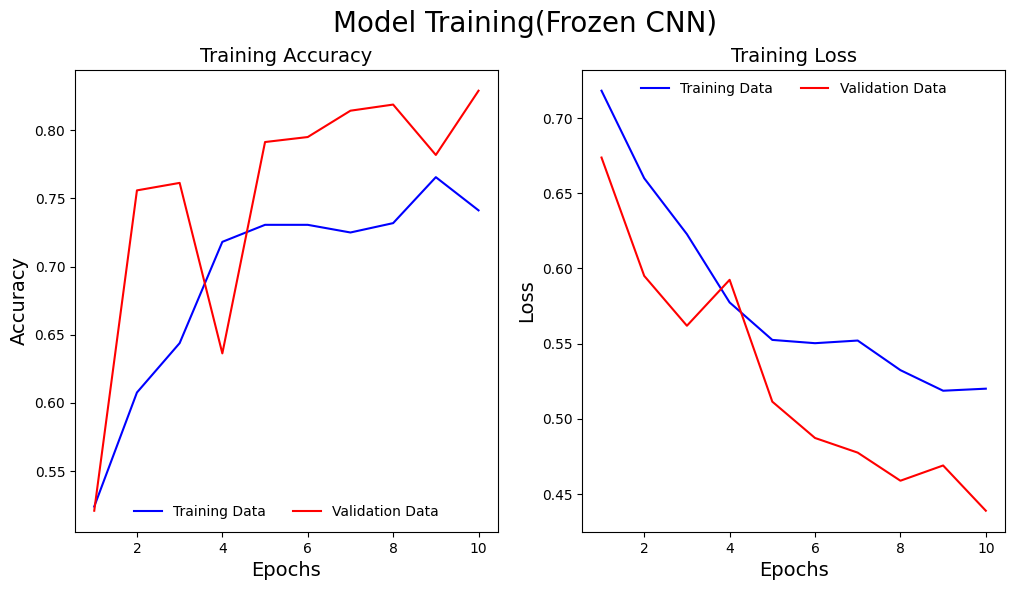

In [37]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training(Frozen CNN)", fontsize=20)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=14)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=14)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Loss', fontsize=14)
ax2.legend(frameon=False, loc='upper center', ncol=2)

In [38]:
# save model
if not os.path.isdir('models/'):
    os.mkdir('models/')
model_01.save_weights(filepath='models/vgg19_model_01.h5', overwrite=True)

In [39]:
# Resize test images similar to the train data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(128, 128),
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  seed=42,
                                                  color_mode='rgb')

Found 5560 images belonging to 2 classes.


In [40]:
# Load the saved model
model_01.load_weights('models/vgg19_model_01.h5')
# Evaluate the model on the hold out validation and test datasets

# Evaluate the model on batches of validation and testing data
vgg_val_eval_01 = model_01.evaluate_generator(valid_generator)
vgg_test_eval_01 = model_01.evaluate_generator(test_generator)

print('Validation loss:     {0:.2f}'.format(vgg_val_eval_01[0]))
print('Validation accuracy: {0:.2f}'.format(vgg_val_eval_01[1]))
print('Test loss:           {0:.2f}'.format(vgg_test_eval_01[0]))
print('Test accuracy:       {0:.2f}'.format(vgg_test_eval_01[1]))

Validation loss:     0.44
Validation accuracy: 0.83
Test loss:           0.44
Test accuracy:       0.83


In [41]:
filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_01 = model_01.predict_generator(test_generator,
                                                steps = nb_samples,
                                                verbose=1)
vgg_pred_labels_01= np.argmax(vgg_predictions_01, axis=1)


5560/5560 [==============================] - 39s 7ms/step


In [42]:
from sklearn.metrics import confusion_matrix, roc_curve,auc, classification_report, precision_score, recall_score

# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_01,
                            target_names=['healthy', 'infected']))
vgg_conf_mat_01 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_01),
                        index=['healthy', 'infected'],
                        columns=['healthy', 'infected'])


              precision    recall  f1-score   support

     healthy       0.85      0.80      0.82      2780
    infected       0.81      0.86      0.83      2780

    accuracy                           0.83      5560
   macro avg       0.83      0.83      0.83      5560
weighted avg       0.83      0.83      0.83      5560



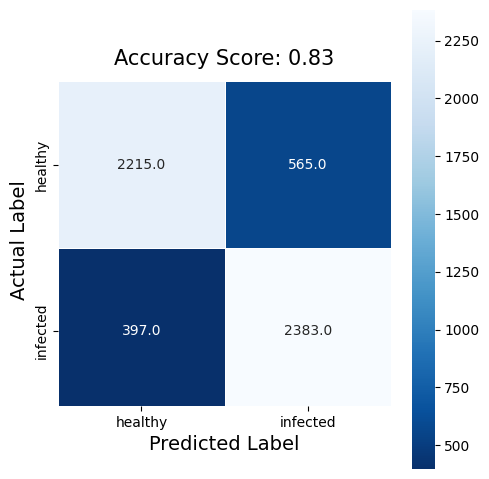

In [43]:
fig, ax = plt.subplots(figsize=(5,5))
#plt.figure(figsize=(9,9))
sns.heatmap(vgg_conf_mat_01, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Blues_r')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_01[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_01)-0.05, -0.05)
plt.tight_layout()

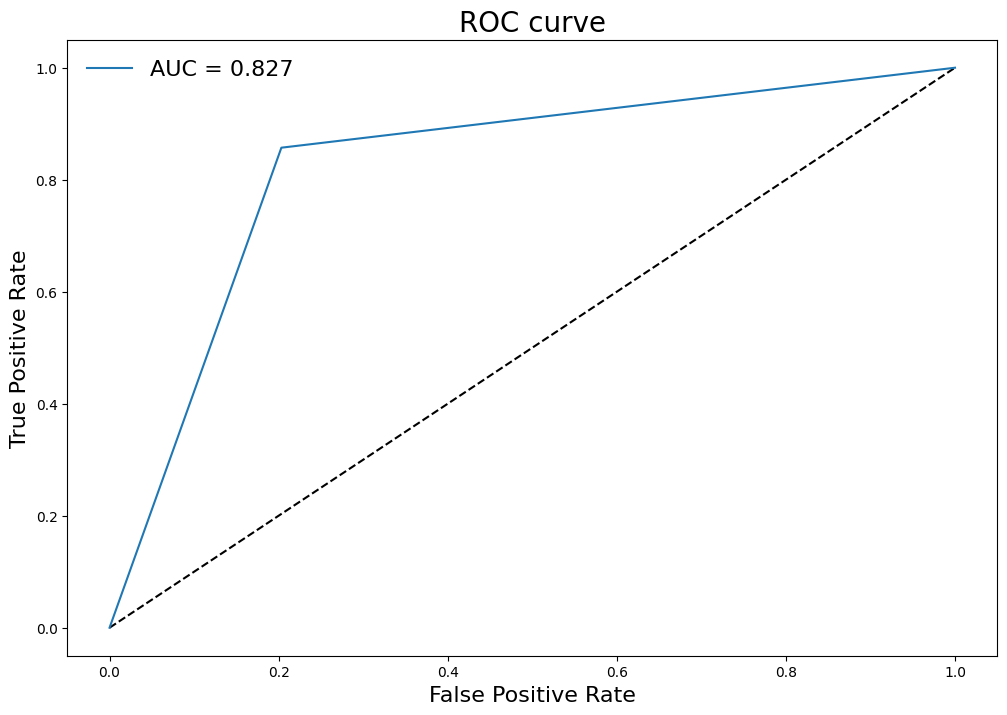

In [44]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_01)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

# **Incremental Unfreezing and Fine Tuning**

In [46]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output

flat=Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('models/vgg19_model_01.h5')

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [47]:
sgd = legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#model_02 = Model(base_model.inputs, output)
model_02.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [48]:
history_02 = model_02.fit(train_generator,
                                 steps_per_epoch=10,
                                 epochs=10,
                                 callbacks = [es, cp, lrr],
                                 validation_data = valid_generator)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.6093 - accuracy: 0.7125
Epoch 1: val_loss did not improve from 0.43876
10/10 [==============================] - 16s 1s/step - loss: 0.6093 - accuracy: 0.7125 - val_loss: 0.7860 - val_accuracy: 0.5015 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.5897 - accuracy: 0.6875
Epoch 2: val_loss did not improve from 0.43876
10/10 [==============================] - 11s 1s/step - loss: 0.5897 - accuracy: 0.6875 - val_loss: 0.4513 - val_accuracy: 0.7729 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.4507 - accuracy: 0.8000
Epoch 3: val_loss did not improve from 0.43876
10/10 [==============================] - 11s 1s/step - loss: 0.4507 - accuracy: 0.8000 - val_loss: 0.5607 - val_accuracy: 0.7271 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.4519 - accuracy: 0.8125
Epoch 4: val_loss improved from 0.43876 to 0.31872, savin

In [49]:
# save model
if not os.path.isdir('models/'):
    os.mkdir('models/')
model_02.save_weights(filepath='models/vgg19_model_02.h5', overwrite=True)

In [51]:
# Load the saved model
model_02.load_weights('models/vgg19_model_02.h5')
# Evaluate the model on the hold out validation and test datasets

vgg_val_eval_02 = model_02.evaluate_generator(valid_generator)
vgg_test_eval_02 = model_02.evaluate_generator(test_generator)

print('Validation loss:     {}'.format(vgg_val_eval_02[0]))
print('Validation accuracy: {}'.format(vgg_val_eval_02[1]))
print('Test loss:           {}'.format(vgg_test_eval_02[0]))
print('Test accuracy:       {}'.format(vgg_test_eval_02[1]))



Validation loss:     0.2871243357658386
Validation accuracy: 0.8724575042724609
Test loss:           0.27206215262413025
Test accuracy:       0.8807554244995117


In [52]:
filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_02 = model_02.predict_generator(test_generator,
                                                steps = nb_samples,
                                                verbose=1)
vgg_pred_labels_02 = np.argmax(vgg_predictions_02, axis=1)



5560/5560 [==============================] - 39s 7ms/step


In [54]:

# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_02,
                            target_names=['healthy', 'infected']))
vgg_conf_mat_02 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_02),
                        index=['healthy', 'infected'],
                        columns=['healthy', 'infected'])



              precision    recall  f1-score   support

     healthy       0.96      0.79      0.87      2780
    infected       0.82      0.97      0.89      2780

    accuracy                           0.88      5560
   macro avg       0.89      0.88      0.88      5560
weighted avg       0.89      0.88      0.88      5560



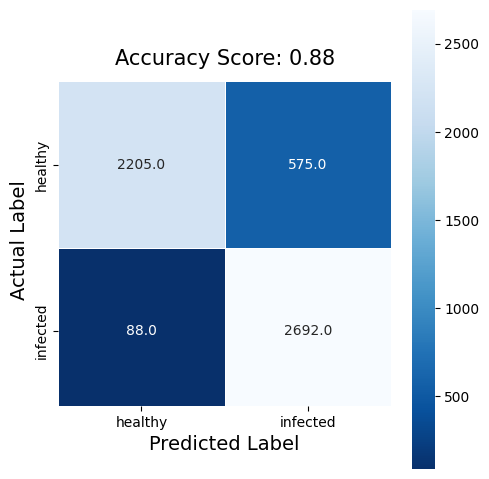

In [55]:

fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_02, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Blues_r')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_02[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_02)-0.05, -0.05)
plt.tight_layout()

In [ ]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_03)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

# **Unfreezing and Fine-tuning the whole network**

In [58]:
# Build the network
base_model = VGG19(include_top=False, input_shape=(128,128,3))
x = base_model.output
flat=Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)
model_03 = Model(base_model.inputs, output)

# Load weights
model_03.load_weights('models/vgg19_model_02.h5')

sgd = legacy.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# Compile the model
model_03.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
history_03 = model_03.fit(train_generator,
                                    steps_per_epoch=100,
                                    epochs=40,
                                    callbacks = [es, cp, lrr],
                                    validation_data = valid_generator)

Epoch 1/40
100/100 [==============================] - ETA: 0s - loss: 0.3650 - accuracy: 0.8491
Epoch 1: val_loss improved from 0.28532 to 0.18838, saving model to best_model.h5
100/100 [==============================] - 48s 433ms/step - loss: 0.3650 - accuracy: 0.8491 - val_loss: 0.1884 - val_accuracy: 0.9330 - lr: 1.0000e-04
Epoch 2/40
100/100 [==============================] - ETA: 0s - loss: 0.3294 - accuracy: 0.8706
Epoch 2: val_loss improved from 0.18838 to 0.18036, saving model to best_model.h5
100/100 [==============================] - 36s 361ms/step - loss: 0.3294 - accuracy: 0.8706 - val_loss: 0.1804 - val_accuracy: 0.9356 - lr: 1.0000e-04
Epoch 3/40
100/100 [==============================] - ETA: 0s - loss: 0.3136 - accuracy: 0.8741
Epoch 3: val_loss improved from 0.18036 to 0.16402, saving model to best_model.h5
100/100 [==============================] - 40s 400ms/step - loss: 0.3136 - accuracy: 0.8741 - val_loss: 0.1640 - val_accuracy: 0.9436 - lr: 1.0000e-04
Epoch 4/40
10

In [60]:
# save model
if not os.path.isdir('models/'):
    os.mkdir('models/')
model_03.save_weights(filepath='models/vgg_unfrozen.h5', overwrite=True)

In [61]:
# Load the saved model
model_03.load_weights('models/vgg_unfrozen.h5')
# Evaluate the model on the hold out validation and test datasets

vgg_val_eval_03 = model_03.evaluate_generator(valid_generator)
vgg_test_eval_03 = model_03.evaluate_generator(test_generator)

print('Validation loss     :{0:.2f}'.format(vgg_val_eval_03[0]))
print('Validation accuracy :{0:.2f}'.format(vgg_val_eval_03[1]))
print('Test loss           :{0:.2f}'.format(vgg_test_eval_03[0]))
print('Test accuracy       :{0:.2f}'.format(vgg_test_eval_03[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_03 = model_03.predict_generator(test_generator,
                                                steps = nb_samples,
                                                verbose=1)
vgg_pred_labels_03 = np.argmax(vgg_predictions_03, axis=1)


Validation loss     :0.17
Validation accuracy :0.94
Test loss           :0.16
Test accuracy       :0.94
5560/5560 [==============================] - 39s 7ms/step


In [62]:
# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_03,
                            target_names=['healthy', 'infected']))
vgg_conf_mat_03 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_03),
                        index=['healthy', 'infected'],
                        columns=['healthy', 'infected'])


              precision    recall  f1-score   support

     healthy       0.98      0.90      0.94      2780
    infected       0.91      0.98      0.95      2780

    accuracy                           0.94      5560
   macro avg       0.95      0.94      0.94      5560
weighted avg       0.95      0.94      0.94      5560



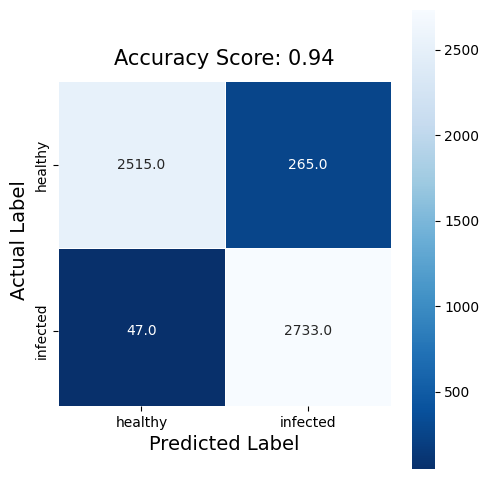

In [63]:
fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_03, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Blues_r')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_03[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_03)-0.05, -0.05)
plt.tight_layout()

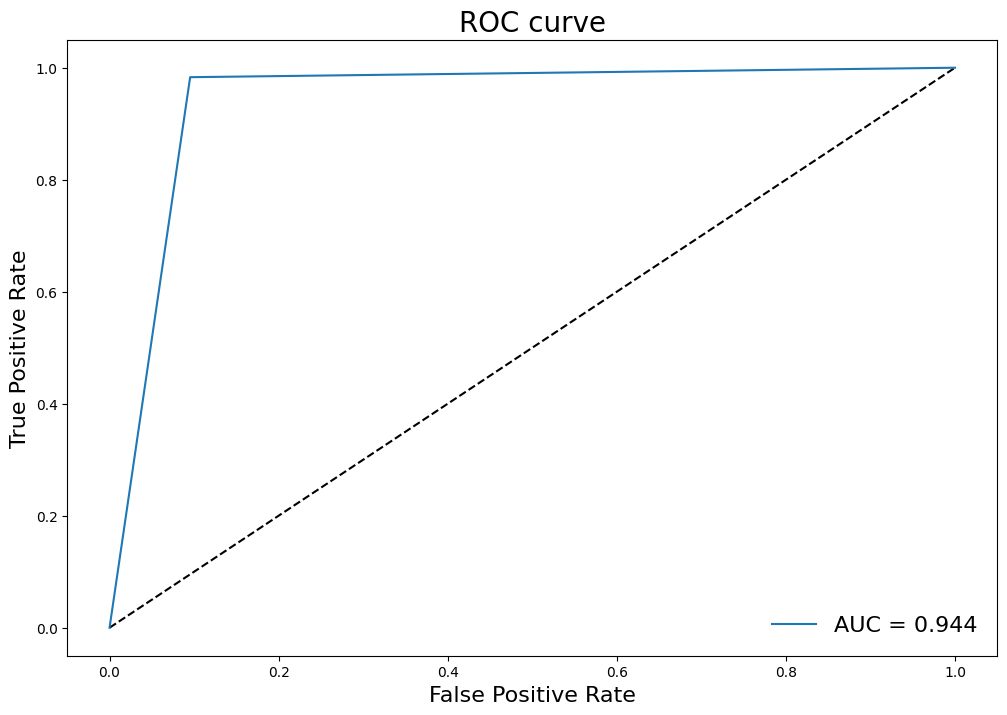

In [64]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_03)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)